AutoGluon - Predicción de ventas (tn) por producto para febrero 2020

In [4]:
# 📦 1. Importar librerías
import pandas as pd
import os

In [5]:
# 💬 Instalar AutoGluon si es necesario
#!pip install autogluon.timeseries
#!pip install autogluon --timeout 100

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [6]:
# 📄 2. Cargar datasets
df_sellin = pd.read_csv("../input/sell-in.txt", sep="\t")
print(f"Datos de sell-in cargados: {df_sellin.shape}")
df_productos = pd.read_csv("../input/tb_productos.txt", sep="\t")
print(f"Datos de productos cargados: {df_productos.shape}")

Datos de sell-in cargados: (2945818, 7)
Datos de productos cargados: (1251, 7)


In [7]:
# 📄 Leer lista de productos a predecir
with open("../input/tb_productos_a_predecir.txt", "r") as f:
    product_ids = [int(line.strip()) for line in f if line.strip().isdigit()]
print(f"Productos a predecir: {len(product_ids)}")

Productos a predecir: 780


In [8]:
# 🧹 3. Preprocesamiento
# Convertir periodo a datetime
df_sellin['timestamp'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')
display(df_sellin.head())

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,timestamp
0,201701,10234,20524,0,2,0.05300,0.05300,2017-01-01
1,201701,10032,20524,0,1,0.13628,0.13628,2017-01-01
2,201701,10217,20524,0,1,0.03028,0.03028,2017-01-01
3,201701,10125,20524,0,1,0.02271,0.02271,2017-01-01
4,201701,10012,20524,0,11,1.54452,1.54452,2017-01-01


In [9]:
# Filtrar hasta dic 2019 y productos requeridos
df_filtered = df_sellin[
    (df_sellin['timestamp'] <= '2019-12-01') &
    (df_sellin['product_id'].isin(product_ids))
]
print(f"Datos filtrados: {df_filtered.shape}")


Datos filtrados: (2293481, 8)


In [10]:
# Agregar tn por periodo, cliente y producto
df_grouped = df_filtered.groupby(['timestamp', 'customer_id', 'product_id'], as_index=False)['tn'].sum()
print(f"Datos agrupados: {df_grouped.shape}")
display(df_grouped.head())

Datos agrupados: (2293481, 4)


,timestamp,customer_id,product_id,tn
0,2017-01-01,10001,20001,99.43861
1,2017-01-01,10001,20002,87.64856
2,2017-01-01,10001,20003,100.21284
3,2017-01-01,10001,20004,21.73954
4,2017-01-01,10001,20006,29.17196


In [11]:
# Agregar tn total por periodo y producto
df_monthly_product = df_grouped.groupby(['timestamp', 'product_id'], as_index=False)['tn'].sum()



print(f"Datos mensuales por producto: {df_monthly_product.shape}")
display(df_monthly_product.head())

Datos mensuales por producto: (22349, 3)


,timestamp,product_id,tn
0,2017-01-01,20001,934.77222
1,2017-01-01,20002,550.15707
2,2017-01-01,20003,1063.45835
3,2017-01-01,20004,555.91614
4,2017-01-01,20005,494.27011


In [12]:
# Agregar columna 'item_id' para AutoGluon
df_monthly_product['item_id'] = df_monthly_product['product_id']
display(df_monthly_product.head())

,timestamp,product_id,tn,item_id
0,2017-01-01,20001,934.77222,20001
1,2017-01-01,20002,550.15707,20002
2,2017-01-01,20003,1063.45835,20003
3,2017-01-01,20004,555.91614,20004
4,2017-01-01,20005,494.27011,20005


In [13]:
# ⏰ 4. Crear TimeSeriesDataFrame


# Renombrar 'product_id' a 'item_id' para static_features_df
static_features = df_productos[['product_id', 'brand', 'cat1', 'cat2', 'cat3']].rename(columns={'product_id': 'item_id'})

ts_data = TimeSeriesDataFrame.from_data_frame(
    df_monthly_product,
    id_column='item_id',
    timestamp_column='timestamp',
    static_features_df=static_features
)

display(ts_data.head())
ts_data.static_features.head()

,,product_id,tn
item_id,timestamp,,
20001,2017-01-01,20001,934.77222
20002,2017-01-01,20002,550.15707
20003,2017-01-01,20003,1063.45835
20004,2017-01-01,20004,555.91614
20005,2017-01-01,20005,494.27011


,brand,cat1,cat2,cat3
item_id,,,,
20001,ARIEL,HC,ROPA LAVADO,Liquido
20002,LIMPIEX,HC,ROPA LAVADO,Liquido
20003,NATURA,FOODS,ADEREZOS,Mayonesa
20004,NATURA,FOODS,ADEREZOS,Mayonesa
20005,NATURA,FOODS,ADEREZOS,Mayonesa


In [14]:
# Análisis de valores nulos por columna
null_values = ts_data.isnull().sum()
print("🔍 Análisis de Valores Nulos por Columna:")
print("="*50)
for col, nulls in null_values.items():
    percentage = (nulls / len(ts_data)) * 100
    print(f"   {col:<20}: {nulls:>3} nulos ({percentage:>5.1f}%)")
print("="*50)

# Completar valores faltantes
#ts_data = ts_data.fill_missing_values()

🔍 Análisis de Valores Nulos por Columna:
   product_id          :   0 nulos (  0.0%)
   tn                  :   0 nulos (  0.0%)


In [15]:
# ⚙️ 5. Definir y entrenar predictor
# prediction_length: número de periodos futuros a predecir (aquí 2 meses: enero y febrero 2020)
# target: nombre de la columna objetivo a predecir, en este caso 'tn'
# freq: frecuencia temporal de los datos, 'MS' significa "Month Start" (inicio de mes)
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    freq='MS',  # Frecuencia mensual (Month Start),
    quantile_levels=[0.05, 0.25, 0.5, 0.75, 0.95]      
)

predictor.fit(ts_data, 
              num_val_windows=2, 
              time_limit=60*60,
              #num_cpus=os.cpu_count() - 1,
              enable_ensemble=True
              )

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\proyectos\labo3-2025r\scripts\AutogluonModels\ag-20250810_155017'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.0
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          20
GPU Count:          1
Memory Avail:       19.96 GB / 31.73 GB (62.9%)
Disk Space Avail:   282.46 GB / 531.97 GB (53.1%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.05, 0.25, 0.5, 0.75, 0.95],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency 'MS'.
Provided train_data has 22375 rows (

In [16]:
predictor.leaderboard(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
	Quantiles to be predicted ([0.05, 0.25, 0.5, 0.75, 0.95]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.
	Quantiles to be predicted ([0.05, 0.25, 0.5, 0.75, 0.95]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.153592,-0.150235,0.416610,0.070560,129.696845,8
1,WeightedEnsemble,-0.153915,-0.133001,10.015458,3.903604,1.090130,13
2,TemporalFusionTransformer,-0.162828,-0.138842,0.340633,0.201673,240.356251,9
3,PatchTST,-0.168386,-0.149907,0.847054,0.355600,48.691051,11
4,ChronosZeroShot[bolt_base],-0.174142,-0.155696,1.788336,1.546005,15.988574,7
5,AutoETS,-0.175008,-0.164182,1.422188,1.681127,1.629197,6
6,DeepAR,-0.178739,-0.153764,0.398808,0.464099,43.161346,10
7,DynamicOptimizedTheta,-0.181408,-0.166902,1.464091,0.394216,1.834912,5
8,DirectTabular,-0.185328,-0.176227,0.298558,0.196042,23.262159,3
9,RecursiveTabular,-0.191510,-0.182156,0.058866,0.039506,1.326468,2


In [17]:
# 🔮 6. Generar predicción
forecast = predictor.predict(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


data with frequency 'IRREG' has been resampled to frequency 'MS'.


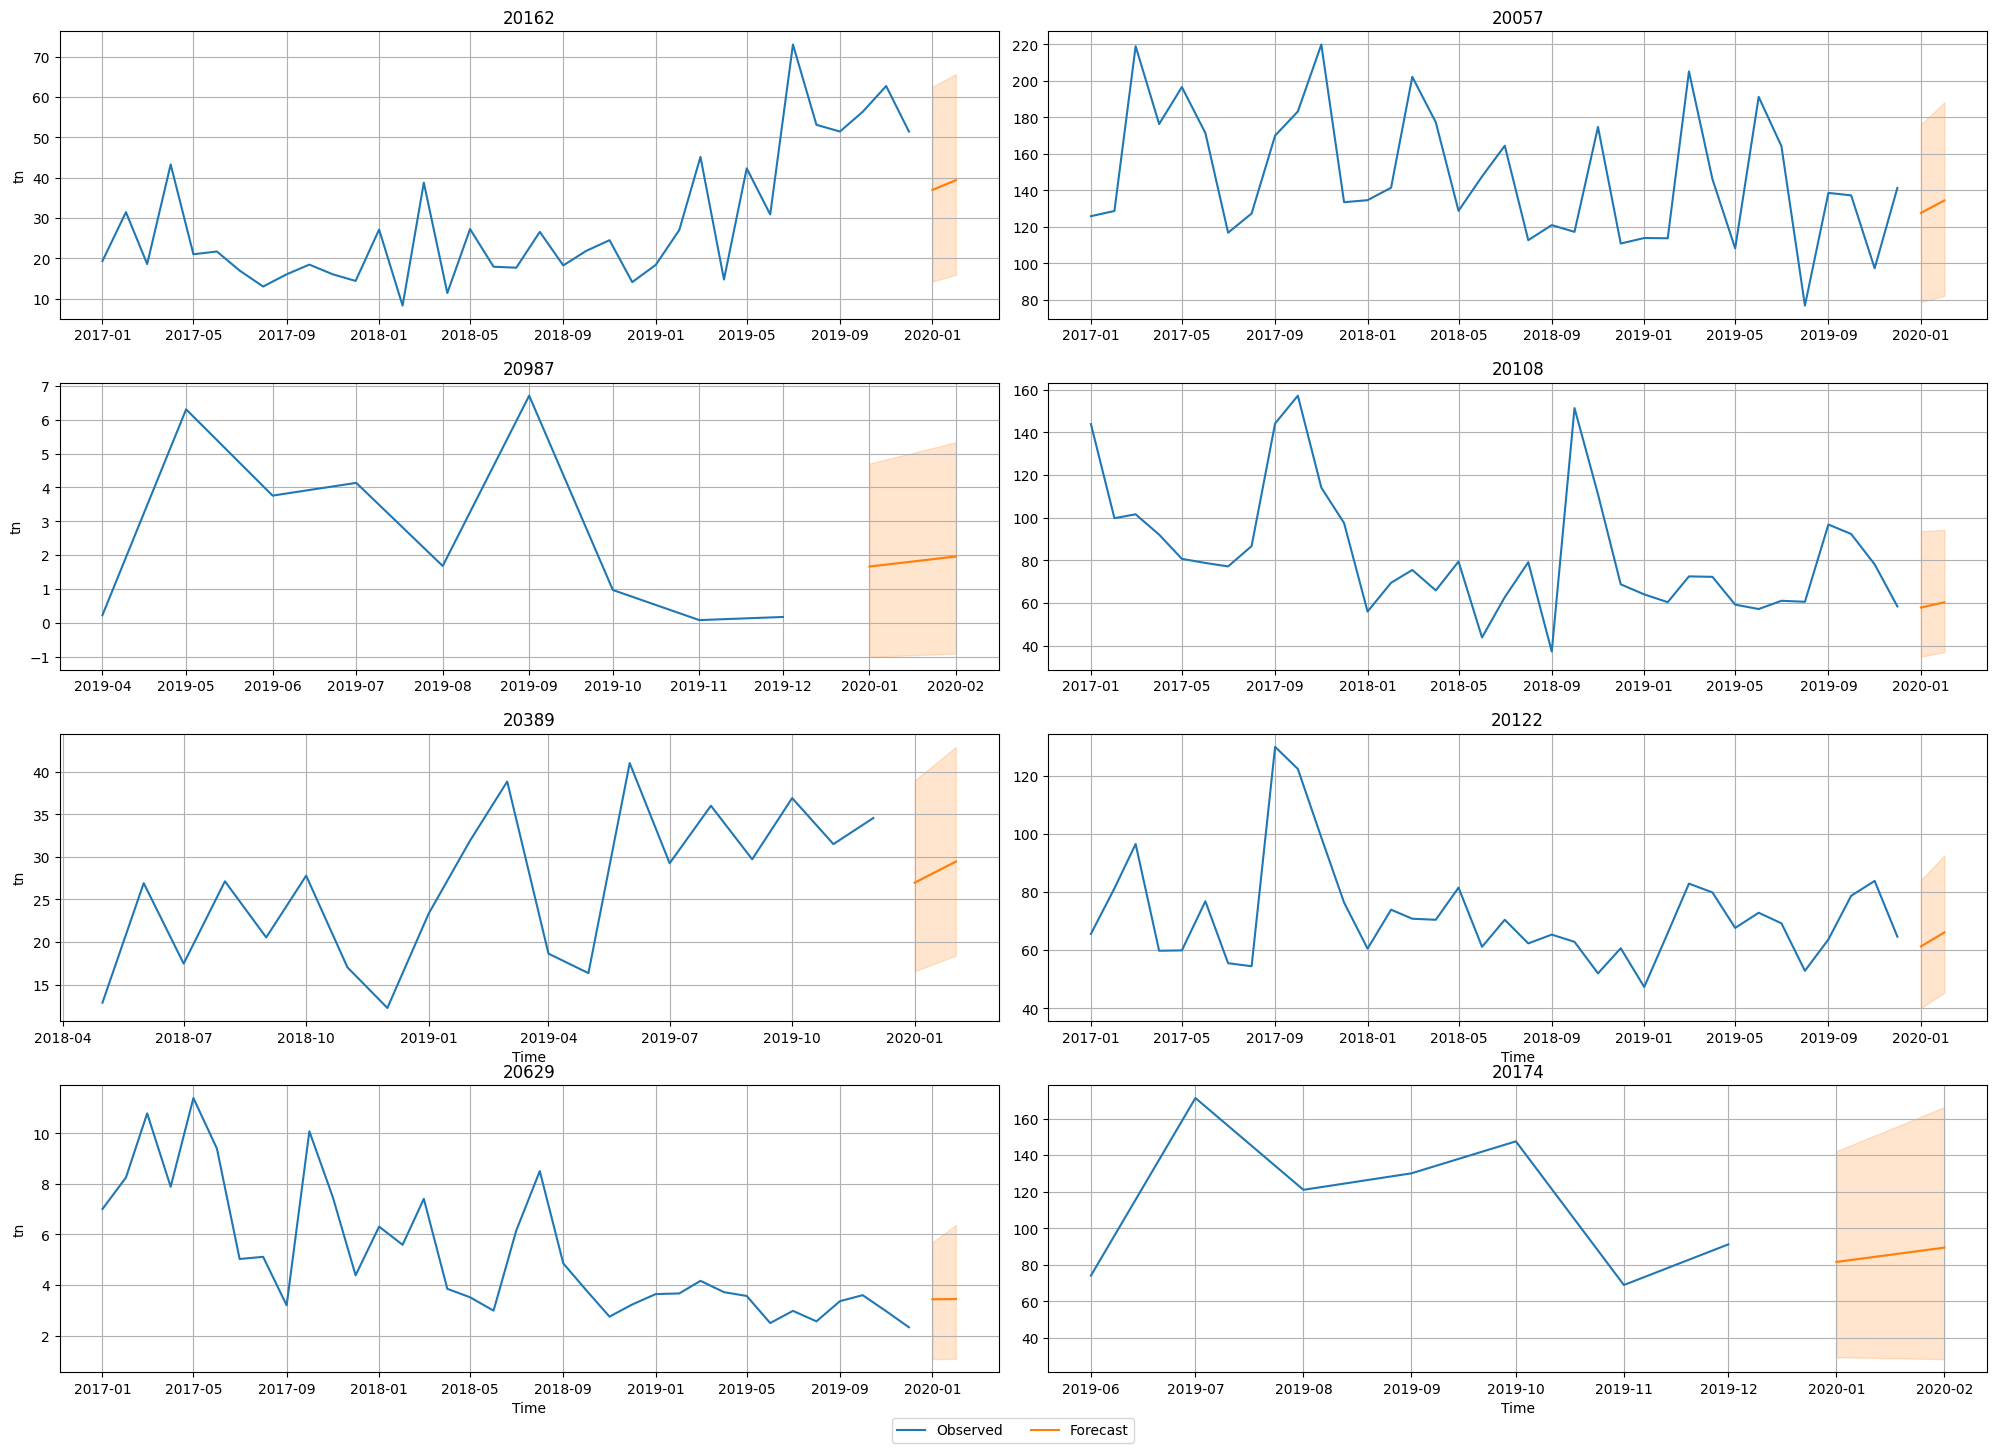

In [25]:
#Graficar
import matplotlib.pyplot as plt
predictor.plot(ts_data, forecast, quantile_levels=[0.05, 0.95], max_history_length=200, max_num_item_ids=8);
plt.show()


In [21]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['mean'].reset_index()
print(forecast_mean.columns)

Index(['item_id', 'timestamp', 'mean'], dtype='object')


In [22]:
# El código toma las predicciones generadas por AutoGluon (almacenadas en el objeto forecast)
# y extrae únicamente la predicción media ('mean') para cada producto (item_id) en febrero 2020.

# 1. Convierte el índice de forecast['mean'] en columnas normales con reset_index().
# 2. Filtra solo las filas donde la columna 'timestamp' es igual a '2020-02-01' (febrero 2020).
# 3. Selecciona solo las columnas 'item_id' y 'mean', que corresponden al identificador del producto y la predicción de toneladas.
# 4. Renombra las columnas a 'product_id' y 'tn' para que sean más descriptivas y compatibles con el resto del flujo de trabajo.

# Así, el DataFrame resultado contiene la predicción de ventas (en toneladas) para cada producto en febrero 2020, listo para guardar o analizar.
# Tomar solo item_id y la predicción 'mean'
resultado = forecast['mean'].reset_index()[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['mean'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']


In [24]:
# 💾 7. Guardar archivo
resultado.to_csv("../output/autogluon/predicciones_auto_gl3.csv", index=False)
resultado.head()

,product_id,tn
1,20001,1306.474570
3,20002,1026.569862
5,20003,684.183132
7,20004,517.509825
9,20005,507.913347
